In [1]:
using LinearAlgebra
using PlotlyJS

include("hubbard_core.jl")

no_particles_from_state (generic function with 1 method)

In [94]:
t = 1
U = 1

const N = 2
const states = reshape(Iterators.product([[0,1] for _ in 1:2N]...) .|> collect, (1, 2^(2N)))
const next = [collect(2:N); 1]

2-element Vector{Int64}:
 2
 1

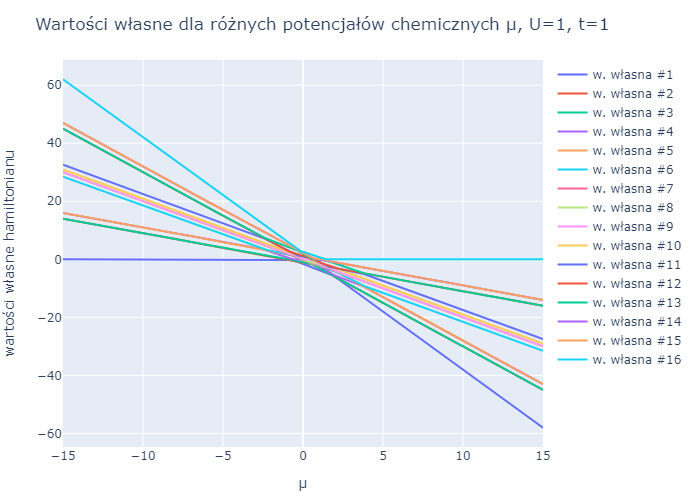

In [41]:
pot_max = 15
pot_step = 0.05
potentials = collect(-pot_max:pot_step:pot_max)
data = [eigen(get_hamiltonian(states, U, t, pot, next, N)) for pot in potentials]
eigs_mat_orig = reduce(hcat,[real(d.values) for d in data])'
eigvecs = [real(d.vectors) for d in data]
eigs_mat = [eigs_mat_orig[:,i] for i in 1:size(eigs_mat_orig,2)]
layout = Layout(
    title="Wartości własne dla różnych potencjałów chemicznych μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="wartości własne hamiltonianu",
)
pl = plot([scatter(x=potentials, y=eig, name="w. własna #$no") for (eig, no) in zip(eigs_mat, 1:(2N)^2)], layout)

In [25]:
[real(d.vectors)[:,1] for d in data][523]

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

Wybieramy stany o najmniejszej energii (dolna krawędź powyższego wykresu):

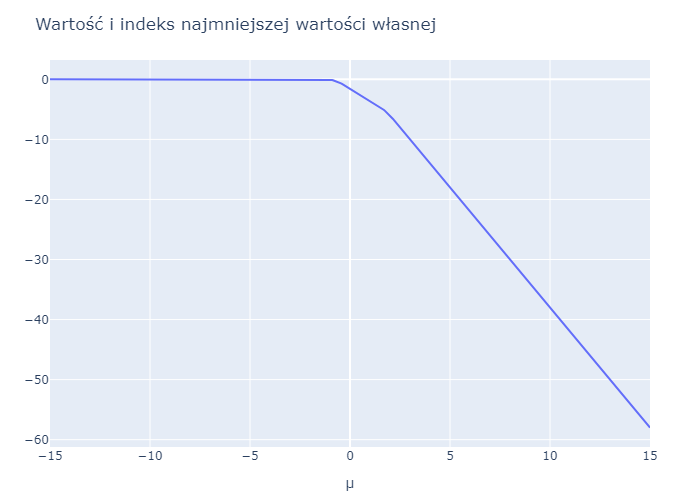

In [26]:
ground_energies = [findmin(eigs_mat_orig[i,:]) for i in 1:size(potentials,1)]
ground_energies = [g[1] for g in ground_energies]
# all_states = [real(eigvecs(get_hamiltonian(states, U, t, pot, next, N))) for pot in potentials]
ground_states = [real(d.vectors)[:,1] for d in data][1]

layout = Layout(
    title="Wartość i indeks najmniejszej wartości własnej",
    xaxis_title="μ",
)
plot(scatter(x=potentials, y=[g for g in ground_energies], name="Wartość"), layout)

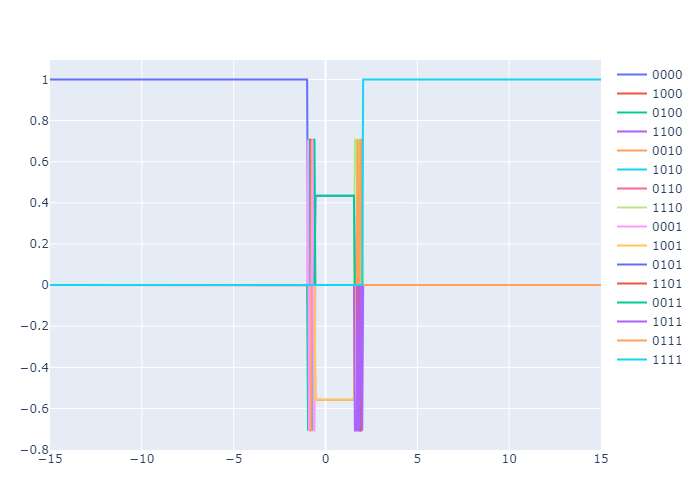

In [67]:
# plot([scatter(x=1:16, y=real(data[1].vectors)[1,i]) for i in 1:16])
# plot([scatter(x=1:16, y=real(eigvecs)[1,i]) for i in 1:16])
eigenvals_sorted = [[eigvecs[pot][:,1][eigv] for pot in 1:601] for eigv in 1:16]
plot([scatter(x=potentials, y=tt, name=reduce(*, string.(statename))) for (tt, statename) in zip(eigenvals_sorted, states)])


Średnia ilość cząstek w stanie, w zależności od potencjału chemicznego:

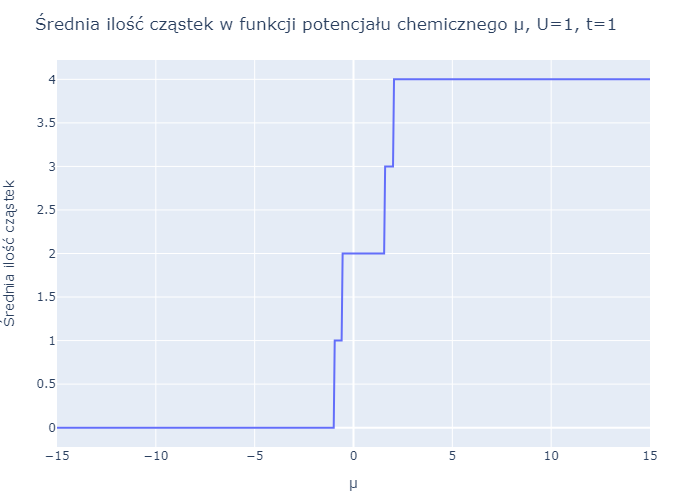

In [134]:
avg_no_particles = [[no_particles_from_state(state, N) for state in 
    [states_row[:, i] for states_row in eigvecs]] for i in 1:2^(2N)]

layout = Layout(
    title="Średnia ilość cząstek w funkcji potencjału chemicznego μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="Średnia ilość cząstek",
)
plot([scatter(x=potentials, y=avg_no_particles[1])], layout)

In [73]:
pot = 3.0
k = 1.0
T = 120
N_matrix = diagm([reduce(+, digits(n, base=2)) for n in 0:((2N)^2 -1)])
H_matrix = get_hamiltonian(states, U, t, pot, next, N)
N_matrix * H_matrix - H_matrix * N_matrix == zeros(16, 16)
[reduce(+, digits(n, base=2)) for n in 0:((2N)^2 -1)]

16-element Vector{Int64}:
 0
 1
 1
 2
 1
 2
 2
 3
 1
 2
 2
 3
 2
 3
 3
 4

In [149]:
U = 1
k = 1.0

function avg_particles_temperature(pot, temperature, N)
    H_matrix = get_hamiltonian(states, U, t, pot, next, N)
    diagonalized = eigen(H_matrix)
    energies = diagonalized.values
    H_states = diagonalized.vectors
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    densities = exp_vec ./stat_sum
    avg_particles = [no_particles_from_state(H_states[:, i], N) for i in 1:(2N)^2]
    avg_particles_temp = reduce(+, densities .* avg_particles)
end

function entropy(pot, temperature, N)
    H_matrix = get_hamiltonian(states, U, t, pot, next, N)
    diagonalized = eigen(H_matrix)
    energies = diagonalized.values
    H_states = diagonalized.vectors
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    densities = exp_vec ./stat_sum
    -k * reduce(+, [abs(p)*log(abs(p)) for p in densities])
end

function Omega_f(pot, temperature, N)
    H_matrix = get_hamiltonian(states, U, t, pot, next, N)
    diagonalized = eigen(H_matrix)
    energies = diagonalized.values
    H_states = diagonalized.vectors
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    return -k*T*log(stat_sum)
end

pots = -2.5:0.01:2.5
trange = round.(10.0.^(range(-1.5,stop=-0.5,length=5)), digits=3)
avg_n = [[avg_particles_temperature(pot, t, N) for pot in pots] for t in trange]
entropy_vals = [[entropy(pot, t) for pot in pots] for t in trange]
helmholtz_vals = [[Omega_f(pot, t, N) + pot*avg_no for (pot, avg_no) in zip(pots, avg_no_rows)] 
    for (t, avg_no_rows) in zip(trange, avg_n)]
U_vals = [[helmholtz + entr*t  for (pot, helmholtz, entr) in zip(pots, helmholtz_vals_rows, entr_rows)]
     for (t, helmholtz_vals_rows, entr_rows) in zip(trange, helmholtz_vals, entropy_vals)]
0

0

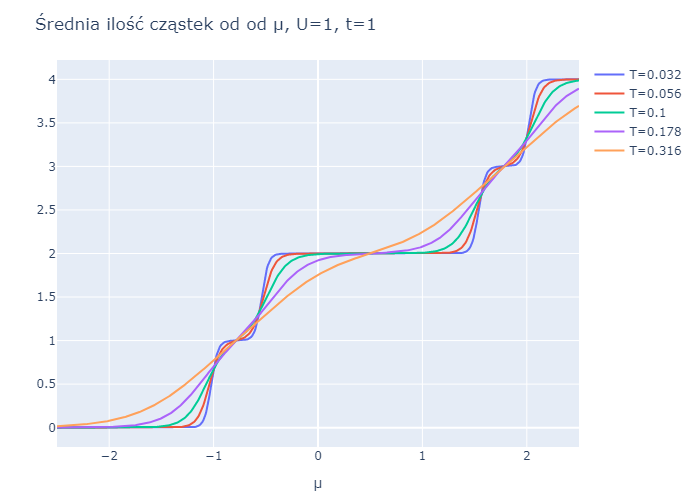

In [151]:
y_vals = avg_n

layout = Layout(
    title="Średnia ilość cząstek od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=pots, y=yval, name="T=$t") for (yval, t) in zip(y_vals, trange)], layout)